Make a grid of stars in the corner sensors, like  https://github.com/suberlak/AOS/blob/main/AOS_DM-31532_rotation_comcam.ipynb  

Use similar code as what was used to set 1 star in the center of sensors in the AOS code (perhaps?)

In [1]:
from lsst.ts.phosim.CloseLoopTask import CloseLoopTask
from lsst.ts.phosim.SkySim import SkySim
from lsst.ts.phosim.OpdMetrology import OpdMetrology
from lsst.ts.phosim.utils.Utility import getCamera
from lsst.afw.cameraGeom import DetectorType, FIELD_ANGLE
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import matplotlib as mpl
from matplotlib import rcParams

rcParams['ytick.labelsize'] = 15
rcParams['xtick.labelsize'] = 15
rcParams['axes.labelsize'] = 20
rcParams['axes.linewidth'] = 2
rcParams['font.size'] = 15
rcParams['axes.titlesize'] = 18
%matplotlib inline

INFO:numexpr.utils:Note: detected 128 virtual cores but NumExpr set to maximum of 64, check "NUMEXPR_MAX_THREADS" environment variable.
INFO:numexpr.utils:Note: NumExpr detected 128 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.


## Make a grid of stars

In [31]:
import lsst.afw.cameraGeom as cameraGeom
from lsst.afw.cameraGeom import PIXELS, FIELD_ANGLE, FOCAL_PLANE
from lsst.geom import Point2D
from astropy.table import Table

def get_donut_grid(radius = 80, margin = 40,xmax = 4000, ymax = 2000):

    xmin = margin+radius
    ymin = xmin

    xlist = np.arange(xmin,xmax-margin, 2*(radius+margin))
    ylist = np.arange(ymin,ymax-margin, 2*(radius+margin))

    x_,y_ = np.meshgrid(xlist,ylist)

    xs = np.ravel(x_)
    ys = np.ravel(y_)

    return xs,ys

instName = "lsst"

# only for instName = "lsst"   
fieldX, fieldY = list(), list()
fieldXrad, fieldYrad = list(), list()
detName = list()
camera = getCamera(instName)
task = CloseLoopTask()

for name in task.getSensorNameListOfFields(instName):
    detector = camera.get(name)
    
    # add grid of points
    xs,ys = get_donut_grid()
    transform = detector.getTransform(PIXELS, FIELD_ANGLE)
    
    # make a list of points in pixels 
    fps = [Point2D(fpx,fpy) for fpx, fpy in zip(xs,ys)]
    
    # transform from pixels to radians 
    pixels = transform.applyForward(fps)

    # this is now in field angle coords, i.e. radians
    fpxRad = [pixel.x for pixel in pixels]
    fpyRad = [pixel.y for pixel in pixels]
    
    # radians to degrees + transpose for phoSim 
    fpyDeg = [np.rad2deg(fp) for fp in fpxRad]
    fpxDeg = [np.rad2deg(fp) for fp in fpyRad]
    
    fieldXrad = np.append(fieldXrad, fpxRad)
    fieldYrad = np.append(fieldYrad, fpyRad)
    fieldX = np.append(fieldX, fpxDeg)
    fieldY = np.append(fieldY, fpyDeg)
    names = [name for i in range(len(fpxDeg))]
    detName = np.append(detName, names)
    
# this is enough information:  fieldX, fieldY in degrees
# to save the star catalog file 

# Save the input catalog 

# make an inst catalog 
coords = Table(data=[fieldX, fieldY],  names=['Ra','Decl'])

# add a column with object id 
ID = np.arange(len(coords))
coords['Id'] = ID
mag = 19
coords['Mag'] = mag
fname = f'/sdf/data/rubin/u/scichris/WORK/AOS/DM-36218/wfs_grid_{mag}.txt'
coords[['Id','Ra','Decl','Mag']].write(fname, 
                                       format='ascii.commented_header',
                                      overwrite=True)
print(f'saved as {fname}')


saved as /sdf/data/rubin/u/scichris/WORK/AOS/DM-36218/wfs_grid_19.txt


Make a table that tells us which point corresponds to which detector ... 

In [32]:
info = Table(data=[ID, fieldX, fieldY, fieldXrad, fieldYrad, detName], names=['Id', 'Ra_deg','Decl_deg',
                                                                             'fieldXrad', 'fieldYrad', 'name'])
info.write(f'/sdf/data/rubin/u/scichris/WORK/AOS/DM-36218/wfs_grid_sensors.txt',
          format='ascii.commented_header', overwrite=True)

## Submit batch job to slurm on S3DF

Make a slurm file  `/sdf/data/rubin/u/scichris/WORK/AOS/DM-36218/runSlurm.sl`, given that we have on USDF 128 cores / node , make ~ 1 task / core :

    #!/bin/bash -l
    #SBATCH --partition roma
    #SBATCH --nodes 3
    #SBATCH --ntasks 180
    #SBATCH -t 100:00:00
    #SBATCH --job-name wfsGrid

    echo "starting at `date` on `hostname`"

    pwd

    python  /sdf/group/rubin/ncsa-home/home/scichris/aos/ts_phosim/bin.src/imgCloseLoop.py --inst lsst --numOfProc 180 --boresightDeg 0.0 0.0 --skyFile /sdf/data/rubin/u/scichris/WORK/AOS/DM-36218/wfs_grid.txt --output  /sdf/data/rubin/u/scichris/WORK/AOS/DM-36218/wfs_grid/

    echo "ended at `date` on `hostname`"

And submit as  `sbatch runSlurm.sl` 


(later  - are there more nodes available to condor? https://sdf.slac.stanford.edu/public/doc/#/batch-compute  ) 

This runs with 

    /sdf/data/rubin/u/scichris/WORK/AOS/DM-36218/wfs_grid/iter0/pert/starWfs.inst
    /sdf/data/rubin/u/scichris/WORK/AOS/DM-36218/wfs_grid/iter0/pert/star.cmd
    /sdf/data/rubin/u/scichris/WORK/AOS/DM-36218/wfs_grid/iter0/img/wfs/starWfsPhosim.log 



## Run with quickbackground in the cmd file 

    cd /sdf/home/s/scichris/link_to_scichris/link_to_ncsa_home_aos/ts_phosim/policy/cmdFile/
    cp /sdf/home/s/scichris/link_to_scichris/link_to_ncsa_project_aos/masks_DM-33104/wfs/starDefaultQckBg.cmd .

    mv starDefault.cmd starDefault_old.cmd
    mv starDefaultQckBg.cmd starDefault.cmd

effectively modifying  `starDefault.cmd` to include:
    
        index f6e6274..e221e37 100644
        --- a/policy/cmdFile/starDefault.cmd
        +++ b/policy/cmdFile/starDefault.cmd
        @@ -1,4 +1,4 @@
        -backgroundmode 0
        +quickbackground
         raydensity 0.0


So now we can run the same `inst` file as above, making sure the output is written to a new directory: 

cd  /sdf/data/rubin/u/scichris/WORK/AOS/DM-36218/

cp runSlurm.sl runSlurmQck.sl


First run with `19` mag : 
    
    
    
convertReferenceCatalog /sdf/data/rubin/u/scichris/WORK/AOS/DM-36218/wfs_grid_19_qck/phosimData/skydata /sdf/data/rubin/u/scichris/WORK/AOS/DM-36218/wfs_grid_19_qck/phosimData/skydata/cat.cfg /sdf/data/rubin/u/scichris/WORK/AOS/DM-36218/wfs_grid_19_qck/phosimData/skydata/sky_data.csv &> /sdf/data/rubin/u/scichris/WORK/AOS/DM-36218/wfs_grid_19_qck/phosimData/skydata/convert.log


Traceback (most recent call last):
  File "/sdf/group/rubin/sw/conda/envs/lsst-scipipe-5.0.0/share/eups/Linux64/meas_algorithms/gee093eeb90+090bb8ed26/bin/convertReferenceCatalog"
, line 7, in <module>
    main()
  File "/sdf/group/rubin/sw/conda/envs/lsst-scipipe-5.0.0/share/eups/Linux64/meas_algorithms/gee093eeb90+090bb8ed26/python/lsst/meas/algorithms/
convertReferenceCatalog.py", line 511, in main
    run_convert(args.outputDir, args.configFile, args.fileglob[0])
  File "/sdf/group/rubin/sw/conda/envs/lsst-scipipe-5.0.0/share/eups/Linux64/meas_algorithms/gee093eeb90+090bb8ed26/python/lsst/meas/algorithms/
convertReferenceCatalog.py", line 489, in run_convert
    converter = ConvertReferenceCatalogTask(output_dir=outputDir, config=config)
  File "/sdf/group/rubin/sw/conda/envs/lsst-scipipe-5.0.0/share/eups/Linux64/meas_algorithms/gee093eeb90+090bb8ed26/python/lsst/meas/algorithms/
convertReferenceCatalog.py", line 296, in __init__
    super().__init__(**kwargs)
  File "/sdf/group/rubin/sw/conda/envs/lsst-scipipe-5.0.0/share/eups/Linux64/pipe_base/ga5243454e3+5a8ca7b25e/python/lsst/pipe/base/task.py", li
ne 203, in __init__
    self.config.validate()
  File "/sdf/group/rubin/sw/conda/envs/lsst-scipipe-5.0.0/share/eups/Linux64/meas_algorithms/gee093eeb90+090bb8ed26/python/lsst/meas/algorithms/
convertReferenceCatalog.py", line 228, in validate
    super().validate()
  File "/sdf/group/rubin/sw/conda/envs/lsst-scipipe-5.0.0/share/eups/Linux64/pex_config/g4891f08dc1+374862e458/python/lsst/pex/config/config.py"
, line 1494, in validate
    field.validate(self)
  File "/sdf/group/rubin/sw/conda/envs/lsst-scipipe-5.0.0/share/eups/Linux64/pex_config/g4891f08dc1+374862e458/python/lsst/pex/config/configFiel
d.py", line 278, in validate
    value.validate()
  File "/sdf/group/rubin/sw/conda/envs/lsst-scipipe-5.0.0/share/eups/Linux64/pex_config/g4891f08dc1+374862e458/python/lsst/pex/config/config.py"
, line 1494, in validate
    field.validate(self)
  File "/sdf/group/rubin/sw/conda/envs/lsst-scipipe-5.0.0/share/eups/Linux64/pex_config/g4891f08dc1+374862e458/python/lsst/pex/config/config.py"
, line 584, in validate
    raise FieldValidationError(self, instance, "Required value cannot be None")
lsst.pex.config.config.FieldValidationError: Field 'dataset_config.ref_dataset_name' failed validation: Required value cannot be None
For more information see the Field definition at:
  File meas/algorithms/convertReferenceCatalog.py:78 (DatasetConfig) and the Config definition at:
  File meas/algorithms/convertReferenceCatalog.py:67 (<module>)

    
Try running the same pipeline but with default pipeline file: 
    
    
    python  /sdf/group/rubin/ncsa-home/home/scichris/aos/ts_phosim/bin.src/imgCloseLoop.py --inst lsst --numOfProc 60 --boresightDeg 0.0 0.0 --skyFile /sdf/data/rubin/u/scichris/WORK/AOS/DM-36218/wfs_grid_15.txt --output  /sdf/data/rubin/u/scichris/WORK/AOS/DM-36218/wfs_grid_15_test/ 
    
    
  I still get:
    
   
    more  /sdf/data/rubin/u/scichris/WORK/AOS/DM-36218/wfs_grid_15_test/phosimData/skydata/convert.log
    
    
    ...
    File "/sdf/group/rubin/sw/conda/envs/lsst-scipipe-5.0.0/share/eups/Linux64/pex_config/g4891f08dc1+374862e458/python/lsst/pex/config/config.py
", line 584, in validate
    raise FieldValidationError(self, instance, "Required value cannot be None")
lsst.pex.config.config.FieldValidationError: Field 'dataset_config.ref_dataset_name' failed validation: Required value cannot be None
For more information see the Field definition at:
  File meas/algorithms/convertReferenceCatalog.py:78 (DatasetConfig) and the Config definition at:
  File meas/algorithms/convertReferenceCatalog.py:67 (<module>)
    
    
    
Try removing the skyfile as well, effectively running the default configuration ...  Also, I made sure that all AOS packages are on `develop` , and up-to-date....
    
    
    python  /sdf/group/rubin/ncsa-home/home/scichris/aos/ts_phosim/bin.src/imgCloseLoop.py --inst lsst --numOfProc 60 --boresightDeg 0.0 0.0  --output  /sdf/data/rubin/u/scichris/WORK/AOS/DM-36218/wfs_test/ 
    
    
    
    still get 
    
    RuntimeError: Error running: 
    convertReferenceCatalog /sdf/data/rubin/u/scichris/WORK/AOS/DM-36218/wfs_test/phosimData/skydata /sdf/data/rubin/u/scichris/WORK/AOS/DM-36218/wfs_test/phosimData/skydata/cat.cfg /sdf/data/rubin/u/scichris/WORK/AOS/DM-36218/wfs_test/phosimData/skydata/sky_data.csv &> /sdf/data/rubin/u/scichris/WORK/AOS/DM-36218/wfs_test/phosimData/skydata/convert.log

In [13]:
import centroid_functions as func 
from astropy.visualization import ZScaleInterval
# Load the stamps
#mag = 18
repo_dir = f'/sdf/data/rubin/u/scichris/WORK/AOS/DM-36218/wfs_test2/phosimData/'
instrument = 'LSSTCam'
collection = 'ts_phosim_9006010'
  
# choose R00 or R44
sensor = 'R00'
#print(f'Fitting {sensor}')
donutStampsExtra, extraFocalCatalog = func.get_butler_stamps(repo_dir,
                                                             instrument=instrument, 
                                      iterN=0, detector=f"{sensor}_SW0",
                                      dataset_type = 'donutStampsExtra', 
                                      collection=collection)

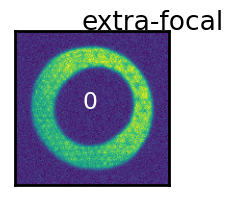

In [17]:
plot_stamps(donutStampsExtra, title='extra-focal', use_zscale=True, nrows=1)

In [18]:
extraImage = func.get_butler_image(repo_dir,instrument=instrument, 
                              iterN=1, detector=f"{sensor}_SW0",
                              collection=collection)

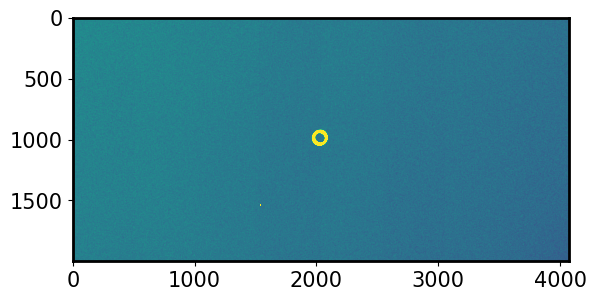

In [19]:
zscale = ZScaleInterval()
data = extraImage.image.array
vmin, vmax = zscale.get_limits(data)
plt.imshow(data,vmin=vmin, vmax=vmax)

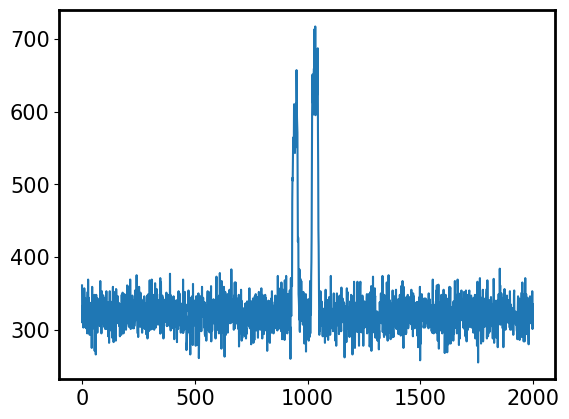

In [20]:
plt.plot(data[:,2000])

So with `quickbackground` we easily see that even the `postISR` still has background at `300` counts level... Is this correct? Shouldn't this background get subtracted at the ISR stage ? 

In [ ]:
pwd


May be that the MJD makes the donut too faint to be seen. Try turning off the background ... 

This is because the background is too strong. Adding  `sunalt -90` to the inst file is needed when using `quickbackground`. After doing that, I run again:

python  /sdf/group/rubin/ncsa-home/home/scichris/aos/ts_phosim/bin.src/imgCloseLoop.py --inst lsst --numOfProc 60 --boresightDeg 0.0 0.0  --output  /sdf/data/rubin/u/scichris/WORK/AOS/DM-36218/wfs_test2/ 

In [ ]:
Note: even adding 

# Plot the resulting iter0 images from imgCloseLoop

Let's check the iter0 images and donut postage stamps, since that's what's most interesting for me 

Can select either `15` , `16`,  `17`, `18`  - these are grids of stars of different magnitudes

All same magnitude, so that the only differing thing are degrees of vignetting.



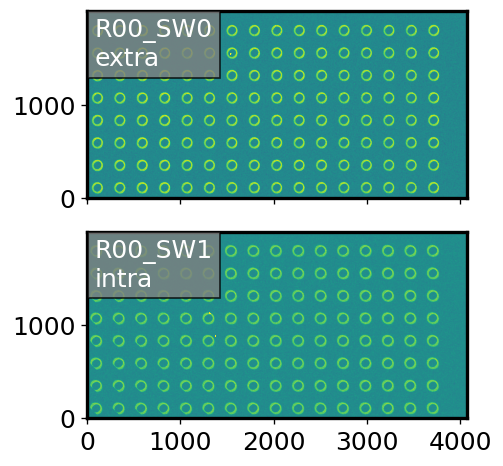

In [12]:
import centroid_functions as func 
from astropy.visualization import ZScaleInterval
# Load the stamps
mag = 18
repo_dir = f'/sdf/data/rubin/u/scichris/WORK/AOS/DM-36218/wfs_grid_{mag}/phosimData/'
instrument = 'LSSTCam'
collection = 'ts_phosim_9006000'
  
# choose R00 or R44
sensor = 'R00'
#print(f'Fitting {sensor}')
donutStampsExtra, extraFocalCatalog = func.get_butler_stamps(repo_dir,
                                                             instrument=instrument, 
                                      iterN=0, detector=f"{sensor}_SW0",
                                      dataset_type = 'donutStampsExtra', 
                                      collection=collection)

donutStampsIntra, intraFocalCatalog = func.get_butler_stamps(repo_dir,
                                                             instrument=instrument, 
                                      iterN=0, detector=f"{sensor}_SW1",
                                      dataset_type = 'donutStampsIntra', 
                                      collection=collection)

extraImage = func.get_butler_image(repo_dir,instrument=instrument, 
                              iterN=0, detector=f"{sensor}_SW0",
                              collection=collection)

intraImage = func.get_butler_image(repo_dir,instrument=instrument, 
                              iterN=0, detector=f"{sensor}_SW1",
                              collection=collection)
pixelScaleArcsec = extraImage.getWcs().getPixelScale().asArcseconds()


zscale = ZScaleInterval()

if sensor[1] == sensor[2]:
    ncols=1; nrows=2
else:
    ncols=2; nrows=1

fig, ax = plt.subplots(ncols=ncols, nrows=nrows, figsize=(4, 4), sharex=True, sharey=True, dpi=120)

# intra is more vignetted
if sensor[1] == "4":

    ax = ax[::-1]

# plot the extrafocal chip
i=0
for exposure, label in zip([extraImage, intraImage], ['extra','intra']):
    data = exposure.image.array
    vmin, vmax = zscale.get_limits(data)
    ax[i].imshow(data, vmin=vmin,vmax=vmax,origin="lower")
    ax[i].text(0.02, 0.96, f"{ exposure.getInfo().getDetector().getName()}\n{label}", 
    transform=ax[i].transAxes, ha="left", va="top", c="w",fontsize=15,
             bbox=dict(facecolor='grey', alpha=0.8, edgecolor='black'))
    i+=1


plt.tight_layout()
plt.show()



Overplot the numbering of donuts on both images 

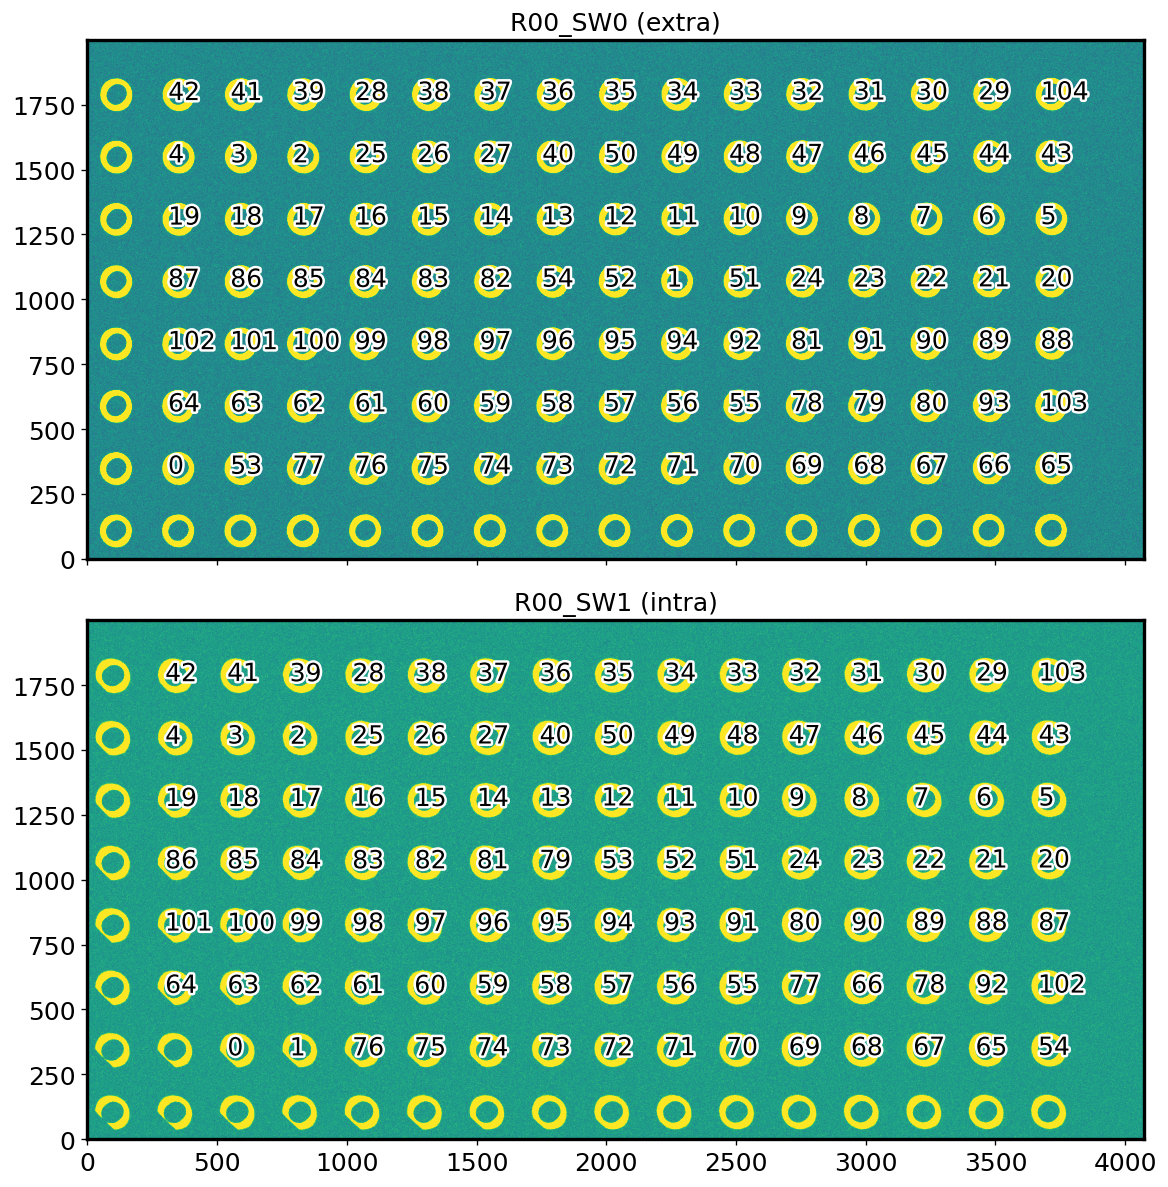

In [51]:
import matplotlib.patheffects as patheffects


fig, ax = plt.subplots(ncols=ncols, nrows=nrows, figsize=(10, 10), sharex=True, sharey=True, dpi=120)

# intra is more vignetted
if sensor[1] == "4":

    ax = ax[::-1]

    
# plot the extrafocal chip
i=0
for exposure, label, donut_stamps in zip([extraImage, intraImage], ['extra','intra'],
                                        [donutStampsExtra, donutStampsIntra]):
    data = exposure.image.array
    vmin, vmax = zscale.get_limits(data)
    ax[i].imshow(data, vmin=vmin,vmax=vmax,origin="lower")
    ax[i].set_title( f"{ exposure.getInfo().getDetector().getName()} ({label})", 
                     fontsize=15,)
             
    # find out how many colors we need for text - different for each axis 
    ndonuts = len(donut_stamps)
    color_idx = np.linspace(0, 1, ndonuts)
    ax_legend_handles = []
    #cmap = plt.cm.plasma 
    for j in range(ndonuts):
        
        #color = cmap(color_idx[j])
        
        
        donut = donut_stamps[j]
        xy = donut.centroid_position

        # plot the cross marking that the donut was used
        #ax[i].scatter(xy[0], xy[1], s=20, marker="+", c="m", lw=2)
        
        #plot the donut number on the plot
        xtext, ytext = xy[0], xy[1]
        xtext -= 40
        ytext -= 20
      
        ax[i].text(xtext, ytext, f"{j}", fontsize=15, c='black', 
                   path_effects=[patheffects.withStroke(linewidth=3,
                                                        foreground="w")])
    i+=1

plt.tight_layout()
#$plt.show()
plt.savefig(f'DM-36218/{sensor}_intra_extra_mag-{mag}_donuts.png', bbox_inches='tight')

Code to identify donuts with hot pixels. This is done by comparing the zscale vmin/vmax to global vmin, vmax




In [3]:
def find_hot_pixels(donutStamps, threshold=3):
    
    hot_dic = {'i':[], 'vmax':[], 'gmax':[]}
    for i in range(len(donutStamps)):
        stamp = donutStamps[i]
        data = stamp.stamp_im.getImage().getArray()
        # find global min/max 
        gmin, gmax = np.min(data), np.max(data)

        # find zscale min, max
        vmin, vmax = zscale.get_limits(data)

        if gmax > threshold*vmax:
            print(i, vmax, gmax, 'potential hot pixel ')
            hot_dic['i'].append(i)
            hot_dic['vmax'].append(vmax)
            hot_dic['gmax'].append(gmax)
    if len(hot_dic['i'])==0:
        print(f'no hot pixels found where global max > {threshold} zscale vmax ')
        
    return hot_dic

In [13]:
hotExtra = find_hot_pixels(donutStampsExtra)

27 53.987667 34442.582 potential hot pixel 


In [14]:
hotIntra = find_hot_pixels(donutStampsIntra)

82 47.96755 34491.113 potential hot pixel 
97 55.963867 34485.117 potential hot pixel 


plot the intra-focal stamps, and turn off the axes since I'm just illustrating the postage stamps 

In [16]:
def plot_stamps(donutStamps, title='intra-focal', use_zscale=True,nrows=10):
    N = len(donutStamps)
    
    zscale = ZScaleInterval()
    
    
    ncols=(N // nrows)
    if N % nrows>0:
        ncols+=1
    fig,axs = plt.subplots(nrows,ncols, figsize=(nrows*2,ncols*2))
    ax = np.ravel(axs)
    i = 0 
    for stamp in donutStamps:
        data =  stamp.stamp_im.getImage().getArray()
        if use_zscale:
            vmin, vmax = zscale.get_limits(data)
            ax[i].imshow(data, vmin=vmin,vmax=vmax, origin='lower')
        else:
            ax[i].imshow(data, origin='lower')
        ax[i].text(70,80, f'{i}', fontsize=17, c='white')
        ax[i].get_xaxis().set_visible(False)
        ax[i].get_yaxis().set_visible(False)
        i += 1 
    M = nrows*ncols
    for i in range(N,M):
        ax[i].axis('off')
    fig.text(0.46, 0.89, title, fontsize=19)

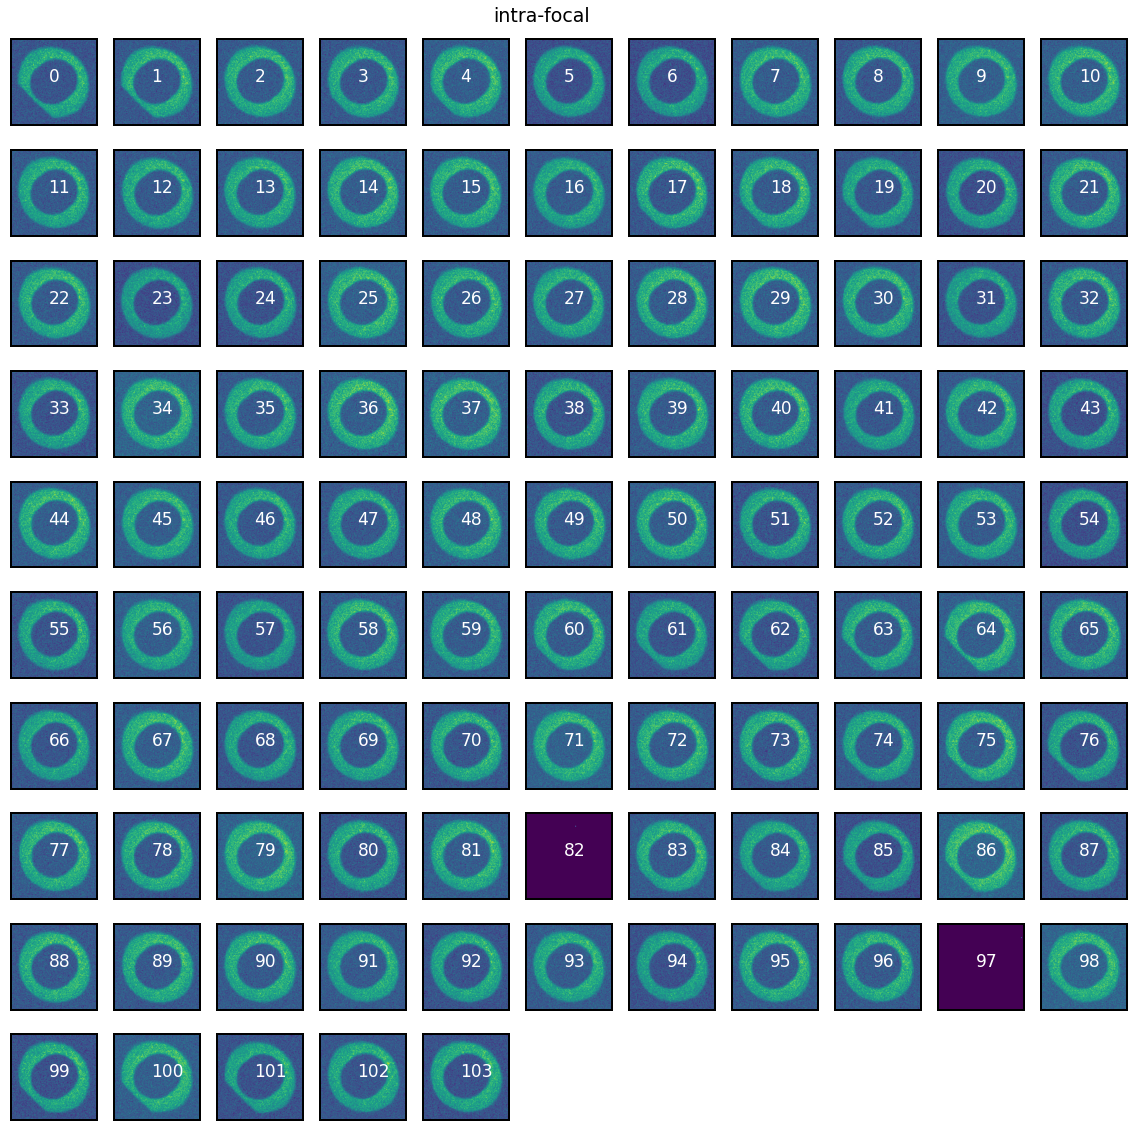

In [9]:
plot_stamps(donutStampsIntra, title='intra-focal', use_zscale=False)

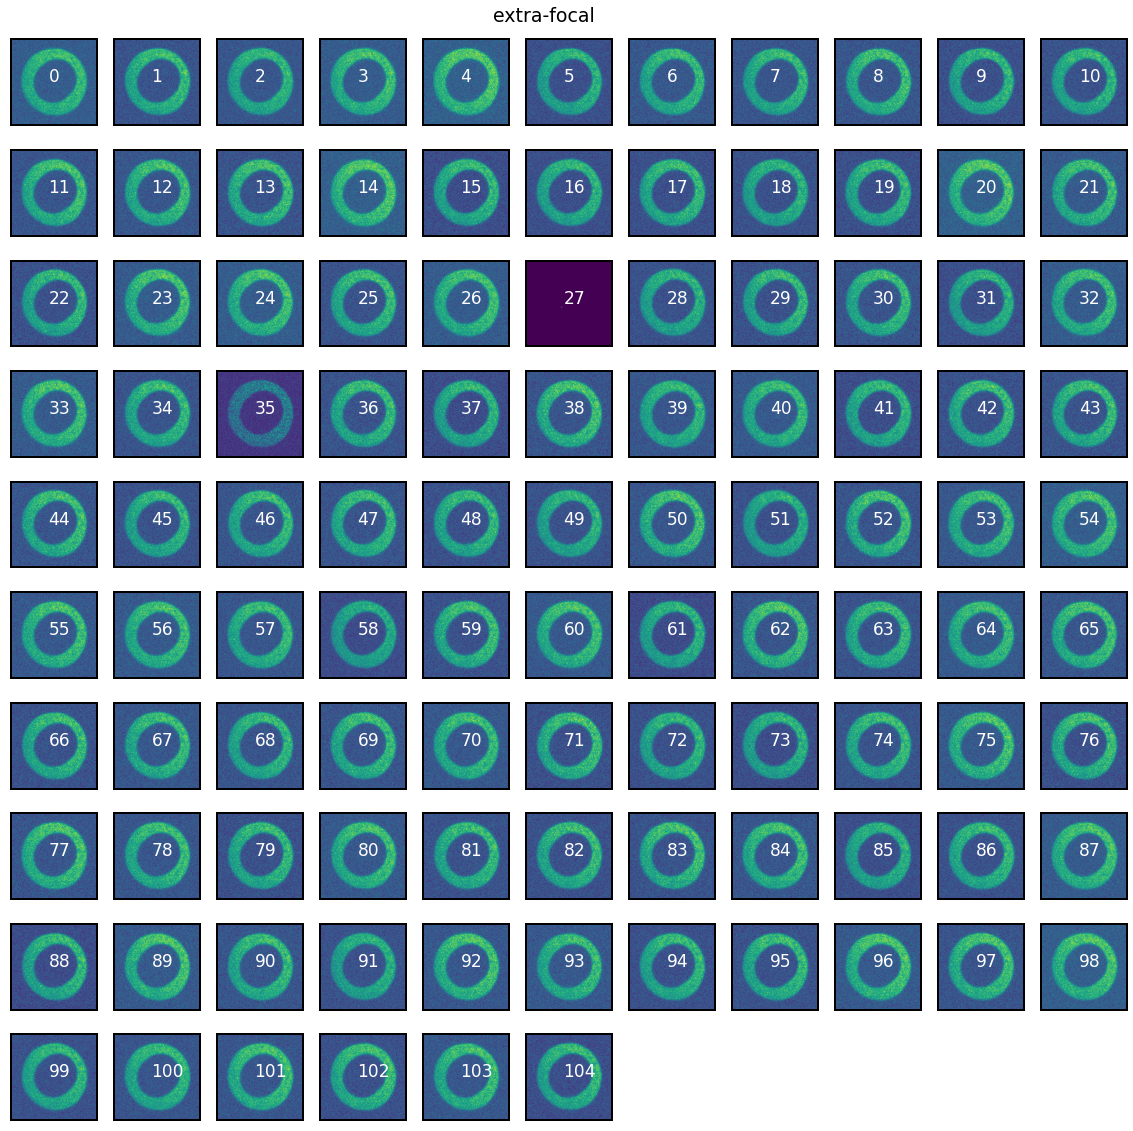

In [10]:
plot_stamps(donutStampsExtra, title='extra-focal', use_zscale=False)

For mag 15, what's going on with stamps 82 and 97 ?  They appear very dark without using `zscale`. This is because they each have very bright hot pixel that messes with `imshow` forcing a very high `vmax`. 

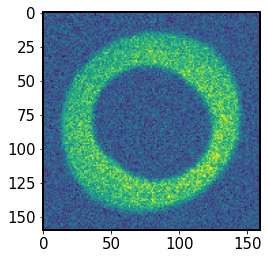

In [54]:
i=82
data = donutStampsIntra[i].stamp_im.getImage().getArray()
vmin, vmax = zscale.get_limits(data)
plt.imshow(data,vmin=vmin,vmax=vmax)

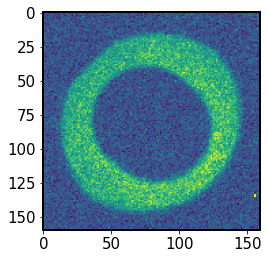

In [55]:
i=97
data = donutStampsIntra[i].stamp_im.getImage().getArray()
vmin, vmax = zscale.get_limits(data)
plt.imshow(data,vmin=vmin,vmax=vmax)

Turns out there's a hot pixel that sets artificially high limit on the stamp. Now that I've added vmin, vmax to all stamps, they look all fine. 

For mag 19, intra-focal 14th stamp is probably incorrectly centered because of hot pixel...

Would need to ignore N=14 for that magnitude



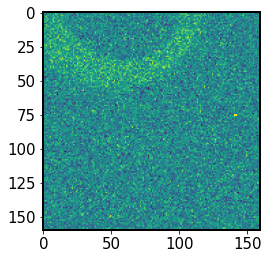

In [12]:
i=14
data = donutStampsIntra[i].stamp_im.getImage().getArray()
vmin, vmax = zscale.get_limits(data)
plt.imshow(data,vmin=vmin,vmax=vmax)

## Compare __version__ of AOS packages...
Doesn't make sense.... donuts are simulated just fine,  but none are cut out into postage stamps! 

The loop should fail in this case rather than keep going with no corrections applied whatsoever...


Let's check versions of `ts_phosim` , `ts_wep`,  `ts_ofc` , and then do `git pull` in the appropriate directory to ensure I have correct ones ...



m

In [125]:
from lsst.ts.phosim import __version__
print(__version__)

v2.0.6-7-g59bfe55


I updated it to v2.0.9 , which only changed the focusZ value to mm ... m

In [126]:
from lsst.ts.wep import __version__
__version__

'unknown'

But given `git log` I was at `40a62fd` which was Aug 15 (PR#145) ... Could this have caused this issue? 

Now I'm up-to-date with v2.7.0



In [127]:
from lsst.ts.ofc import __version__
__version__

'v2.0.1-17-g761a71a'

It was already up-to-date... BTW the tag version above does not match the `git tag` (which indicates that the latest tag is `v2.0.6`...)

Ok, `ts_phosim` has that https://github.com/lsst-ts/ts_phosim/blob/bf49b3865aaa4563948a262d8c6a40ccee63eb2e/setup.py#L35 , which generates `__version__`,  but `ts_wep` lacks `setup.py` altogether ... (do we need to add one?)

   cd /sdf/group/rubin/ncsa-home/home/scichris/aos/

# Rerun the `CloseLoopTask`, making grids of donuts with 16th, 17th, 18th, 19th mag.  

Increase the threshold in `DonutSelectorTask` .

  

Because the entire pipeline file needs to be specified,  I copy one that was created for the previous run, and modify the `magLimit` element... 

Renamed `wfs_grid` to `wfs_grid_16_old` , because that's what it is .. (16th mag stars that did not get selected...)

I copy the `pipelinefile`:

    cp wfs_grid_16_old/phosimData/lsstPipeline.yaml .
    
Modify it with `nano` increasing the magnitude limit:

    referenceSelector.magLimit.maximum: 18.5

I save it as `lsstPipelineIncreaseMagLimit.yaml` 

And run `imgCloseLoop` with the list of `17`th mag stars, `wfs_grid_17.txt`  but with that pipeline yaml file:

      python  /sdf/group/rubin/ncsa-home/home/scichris/aos/ts_phosim/bin.src/imgCloseLoop.py --inst lsst --numOfProc 180 --boresightDeg 0.0 0.0 --skyFile /sdf/data/rubin/u/scichris/WORK/AOS/DM-36218/wfs_grid.txt --output  /sdf/data/rubin/u/scichris/WORK/AOS/DM-36218/wfs_grid/ --pipelineFile /sdf/data/rubin/u/scichris/WORK/AOS/DM-36218/lsstPipelineIncreaseMagLimit.yaml
      
I do the same with `18` mag 


# Simulate  OPD at the locations of the stellar grid 

This amounts to just running phosim to run OPD, and code below to turn that into Zks... I find what command was used to run phosim initially by inspecting the `log` file: 

But because the `perturbations` were simulated differently for each mag, to compare to the correct OPD need to use exactly the same `opd.cmd ` files, but alter the `inst` files 

The output would be parrallel to the existing OPD locations, i.e. `iter0/pert/` for the updated `inst` files, and `iter0/img` for updated images, in the `opdgrid` sub-directory .

From one of the `slurm` output files I get 

    INFO:PHOSIM OPD ARGSTRING: /sdf/data/rubin/u/scichris/WORK/AOS/DM-36218/wfs_grid_18/iter0/pert/opd.inst -i lsst -e 1 -c /sdf/data/rubin/u/scichris/WORK/AOS/DM-36218/wfs_grid_18/iter0/pert/opd.cmd -p 300 -o /sdf/data/rubin/u/scichris/WORK/AOS/DM-36218/wfs_grid_18/iter0/img -w /sdf/data/rubin/u/scichris/WORK/AOS/DM-36218/wfs_grid_18/iter0/img > /sdf/data/rubin/u/scichris/WORK/AOS/DM-36218/wfs_grid_18/iter0/img/opdPhoSim.log 2>&1


that means that the structure of the call is 

    mpython path_to_phosim inst_file -i lsst -e 1 -c cmd_file -p 300 -o out_dir -w out_dir > log_file 2>&1

In [ ]:
Need to write  a new OPD inst file, that takes the positions of the stellar grid from the star


In [27]:
from astropy.table import Table
mag = 17 # this doesn't matter as much for OPD since there aren't any sources being simulated 
fpath =  f'/sdf/data/rubin/u/scichris/WORK/AOS/DM-36218/wfs_grid_{mag}.txt'
starFile = Table.read(fpath, format='ascii.commented_header')


In [24]:
fpath = f'/sdf/data/rubin/u/scichris/WORK/AOS/DM-36218/wfs_grid_15/iter0/pert/opd.inst'
f = open(fpath,"r")
lines = f.readlines()
opd_file_content = []
for line in lines:
    opd_file_content.append(line)
    

In [62]:
#take the beginning, and write in the new opd locations in the same fashion:
idx = 58
opd_keep = opd_file_content[:idx]
opd_locations = opd_file_content[idx:]

# make a list of new star files 
#opd_new_locations = []
for i in range(len(starFile)):
    ra = np.round(starFile[i]['Ra'],6)
    dec = np.round(starFile[i]['Decl'],6)
    line = f'opd  {i}\t {ra}\t {dec} 500.0 \n'
    opd_keep.append(line)

# write to a common opd file that will be used for all OPD simulations 
fpath =  f'/sdf/data/rubin/u/scichris/WORK/AOS/DM-36218/opd_grid.inst' 
fid = open(fpath, "w")
for L in opd_keep: fid.writelines(L) 
fid.close()

In [74]:
from lsst.ts.phosim.utils.Utility import getPhoSimPath
phosimDir = getPhoSimPath()
path_to_phosim = os.path.join(phosimDir, "phosim.py")
mag = 19
inst_file = f'/sdf/data/rubin/u/scichris/WORK/AOS/DM-36218/opd_grid.inst'
cmd_file = f'/sdf/data/rubin/u/scichris/WORK/AOS/DM-36218/wfs_grid_{mag}/iter0/pert/opd.cmd'
out_dir  = f'/sdf/data/rubin/u/scichris/WORK/AOS/DM-36218/wfs_grid_{mag}/iter0/img/opd_grid/'
if not os.path.exists(out_dir):
    os.makedirs(out_dir)
numProc = 256
log_file = f'/sdf/data/rubin/u/scichris/WORK/AOS/DM-36218/wfs_grid_{mag}/iter0/img/opdPhoSimGrid.log'
cmd = f'python {path_to_phosim} {inst_file} -i lsst -e 1 -c {cmd_file} \
-p {numProc} -o {out_dir} -w {out_dir} > {log_file} 2>&1'
print(cmd)

python /sdf/group/rubin/ncsa-home/home/scichris/aos/phosim_syseng4/phosim.py /sdf/data/rubin/u/scichris/WORK/AOS/DM-36218/opd_grid.inst -i lsst -e 1 -c /sdf/data/rubin/u/scichris/WORK/AOS/DM-36218/wfs_grid_19/iter0/pert/opd.cmd -p 256 -o /sdf/data/rubin/u/scichris/WORK/AOS/DM-36218/wfs_grid_19/iter0/img/opd_grid/ -w /sdf/data/rubin/u/scichris/WORK/AOS/DM-36218/wfs_grid_19/iter0/img/opd_grid/ > /sdf/data/rubin/u/scichris/WORK/AOS/DM-36218/wfs_grid_19/iter0/img/opdPhoSimGrid.log 2>&1


The slurm cluster is swamped, so I  try submitting manually - but what's the amount of available cores? 

lscpu 
shows 128 CPUs,  with 64 cores per CPU.

So I should be able to  easily submit a job that would have `-p 32 `...  Need to have N cores available, so if it's 64 cores per CPU, I should be able to set `-p` to be eg. 256 (would only take 4 CPUs)

Inspect the results. Now the sub-directory called `opd_grid` contains over 1000 files, each is the OPD map for a particular grid location... 

## Analyze OPD data

In [12]:
import re
from lsst.ts.phosim.utils.Utility import getConfigDir, sortOpdFileList
from lsst.ts.phosim.OpdMetrology import OpdMetrology

def _getFileInDir(fileDir):
    """Get the files in the directory.
    Parameters
    ----------
    fileDir : str
        File directory.
    Returns
    -------
    list
        List of files.
    """

    fileList = []
    for name in os.listdir(fileDir):
        filePath = os.path.join(fileDir, name)
        if os.path.isfile(filePath):
            fileList.append(filePath)

    return fileList

# _getOpdFileInDir in PhosimCmpt
def _getOpdFileInDir(opdDir):
    opdFileList = []
    fileList = _getFileInDir(opdDir)
    for file in fileList:
        fileName = os.path.basename(file)
        m = re.match(r"\Aopd_\d+_(\d+).fits.gz", fileName)
        if m is not None:
            opdFileList.append(file)
    return opdFileList

# part of self._writeOpdPssnFile(instName, pssnFileName)
# _calcPssnOpd  in PhosimCmpt

def _calcPssnOpd(opdFileList):
    # the reference filter is defined as 500 nm,
    # in https://github.com/lsst-ts/ts_phosim/blob/develop/policy/teleSetting.yaml 
    wavelengthInUm = 500 * 1e-3

    metr = OpdMetrology()
    metr.setCamera('lsst')
    pssnList = []
    for opdFile in opdFileList:
        pssn = metr.calcPSSN(wavelengthInUm, opdFitsFile=opdFile)
        pssnList.append(pssn)
    return pssnList
    # do calculation for the first file 
    #opdFile = opdFileList[0]


In [6]:
#os.listdir(opdDir)

In [14]:
# part of 
# self._writeOpdZkFile(zkFileName, rotOpdInDeg)

from astropy.io import fits

def _writeOpdZkFile(opdFileList, imgDir, zkFileName):
    metr = OpdMetrology()      
    # Map the OPD to the Zk basis and do the collection
    numOfZk = 19
    opdData = np.zeros((len(opdFileList), numOfZk))
    for idx, opdFile in enumerate(opdFileList):
        opd = fits.getdata(opdFile)

        # Rotate OPD if needed - NOT NEEDED 

        # z1 to z22 (22 terms)
        zk = metr.getZkFromOpd(opdMap=opd)[0]

        # Only need to collect z4 to z22
        initIdx = 3
        opdData[idx, :] = zk[initIdx : initIdx + numOfZk]
        
    filePath = os.path.join(imgDir, zkFileName)
    rotOpdInDeg = 0 
    header = (
        "The following are OPD in rotation angle of %.2f degree in um from z4 to z22:"
        % (rotOpdInDeg)
    )
    np.savetxt(filePath, opdData, header=header)


Do that for all the simulated OPDs...

In [16]:
for mag in  range(16,20):
    imgDir = f'/sdf/data/rubin/u/scichris/WORK/AOS/DM-36218/wfs_grid_{mag}/iter0/img/'
    opdDir = os.path.join(imgDir,'opd_grid/' )
    zkFileName = 'opdGrid.zer'
    print(imgDir)
    
    # get opd files
    opdFileList = _getOpdFileInDir(opdDir)

    # Do the sorting of file names
    sortedOpdFileList = sortOpdFileList(opdFileList)

    # calculate zernikes based on OPD and store 
    _writeOpdZkFile(sortedOpdFileList, imgDir, zkFileName)


/sdf/data/rubin/u/scichris/WORK/AOS/DM-36218/wfs_grid_16/iter0/img/
/sdf/data/rubin/u/scichris/WORK/AOS/DM-36218/wfs_grid_17/iter0/img/
/sdf/data/rubin/u/scichris/WORK/AOS/DM-36218/wfs_grid_18/iter0/img/
/sdf/data/rubin/u/scichris/WORK/AOS/DM-36218/wfs_grid_19/iter0/img/


## Read-in the OPD data 

Calculate the median for each  sensor, as well as departure from that. Also, figure out which OPD points are for which sensor... 



In [4]:
import os 
import numpy as np 
mag = 15
imgDir = f'/sdf/data/rubin/u/scichris/WORK/AOS/DM-36218/wfs_grid_{mag}/iter0/img/'
opdDir = os.path.join(imgDir,'opd_grid/' )
zkFileName = 'opdGrid.zer'

opdZkFilePath = os.path.join(imgDir, zkFileName)
opdData = np.loadtxt(opdZkFilePath)

In [5]:
len(opdData)

1024

In [20]:
np.shape(opdData)

(1024, 19)

So it's OPD at 1024  points... Find out where these  points are (i.e. which ones correspond to which detector...)

So given that the `sortedOpdFileList` is sorted, I gather that there's a 1-1 mapping between position in `opdData` and the number in 

The positions are actually identical as in the original star file:
    

In [6]:
from astropy.table import Table
mag = 17 # this doesn't matter as much for OPD since there aren't any sources being simulated 
fpath =  f'/sdf/data/rubin/u/scichris/WORK/AOS/DM-36218/wfs_grid_{mag}.txt'
starFile = Table.read(fpath, format='ascii.commented_header')


But which detector corresponds to which Ra/Dec ? Need to go back to where this file got originally created to find out ... 

In [24]:
#Select points for one detector ... 
info = Table.read(f'/sdf/data/rubin/u/scichris/WORK/AOS/DM-36218/wfs_grid_sensors.txt',
          format='ascii.commented_header', )
ids = info[info['name'] == 'R00_SW1']['Id']

The `Id` is the key to `opdData`.  So select points that correspond to that sensor, and plot the departure from the mean for the points where they were calculated

In [25]:
len(opdData[ids])

128

Plotting  OPD datapoints only for one sensor (eg. `R00_SW0`)

In [26]:
opd = opdData[ids]

In [27]:
#fpath =  f'/sdf/data/rubin/u/scichris/WORK/AOS/DM-36218/opd_grid.inst' 


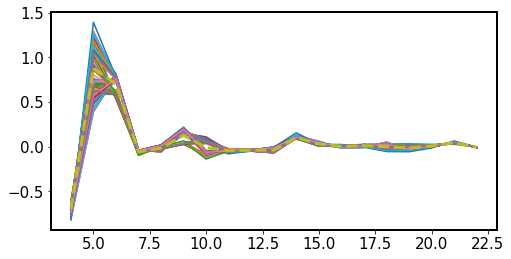

In [28]:
%matplotlib inline
fig,ax = plt.subplots(1,1,figsize=(8,4))
for i in range(len(opd)):
    ax.plot(np.arange(4,23), opd[i])
ax.plot(np.arange(4,23), np.mean(opd, axis=0), ls='--',lw=3)
    

So there is quite a difference! Will be good to calculate a mean , and then show the departure from the mean across the sensor. 

In [29]:
meanOpd = np.mean(opd, axis=0)
rms = []
for i in range(len(opd)):
    diffRms = np.sqrt(np.sum(np.abs(opd[i] - meanOpd) ** 2) / len(opd[i]))
    rms.append(diffRms)

Make a table from the x,y position and the rms departure:

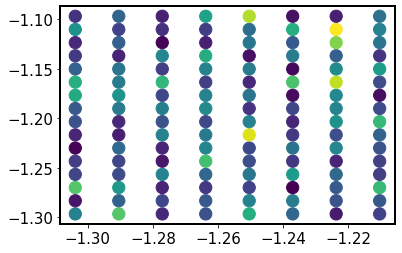

In [30]:
plt.scatter(info[ids]['Ra'], info[ids]['Decl'],  c=rms, s=150)

I don't see much of a gradient ... But make sure to compare the results for group "A" with the median of OPD in that region. Similarly for group "B". 